<a href="https://colab.research.google.com/github/Fernando0211/Machine-Learning/blob/main/Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [19]:
#Libraries to read and modify the dataset
import pandas as pd
import numpy as np
import math
from math import sqrt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import seaborn as sns

#KNN libraries
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report

#Perceptron Multi-Class libraries
from sklearn.linear_model import Perceptron
from sklearn.multiclass import OneVsRestClassifier
from sklearn.datasets import make_classification

# Dataset preprocessing

In [3]:
#Read the dataset using pandas
data = pd.read_csv("Indicadores_municipales_sabana_DA.csv", encoding = "latin-1")

## Null values handling

In [4]:
col_null = data.columns[data.isnull().any()] #Get the columns with null values

for feature in col_null:
    null_rows = data[data[feature].isnull()]  #Get rows with null values


    if pd.api.types.is_numeric_dtype(data[feature]):  #For numeric values, get the mean
        replacement_values = data.groupby('ent')[feature].mean()

    else: #Get the mode for classes values
        replacement_values = data.groupby('ent')[feature].apply(lambda x: x.mode().iloc[0] if not x.mode().empty else None)

    for index, row in null_rows.iterrows(): #Reeplace the mean or mode
        ent_value = row['ent']
        if ent_value in replacement_values:  #Check if a replacement is need in the row
            data.at[index, feature] = replacement_values[ent_value]

In [5]:
y_data = data['gdo_rezsoc10']

mapping = {
    'Muy bajo': 0,
    'Bajo': 1,
    'Medio': 2,
    'Alto': 3,
    'Muy alto': 4
}

y_data.replace(mapping, inplace=True)

## Categories to numeric values

In [6]:
data = data.drop(columns = ["nom_ent", "clave_mun", "nom_mun"]) #Drop features with no relevance

mapping = {
    'Muy bajo': 0,
    'Bajo': 1,
    'Medio': 2,
    'Alto': 3,
    'Muy alto': 4
}

data.replace(mapping, inplace=True) #Change to numeric values the classes, it is in ordinal since the classes has a hierarchy order

In [7]:
data

,ent,mun,pobtot_ajustada,pobreza,pobreza_e,pobreza_m,vul_car,vul_ing,npnv,ic_rezedu,...,pobreza_alim_10,pobreza_cap_90,pobreza_cap_00,pobreza_cap_10,pobreza_patrim_90,pobreza_patrim_00,pobreza_patrim_10,gini_90,gini_00,gini_10
0,1,1,794304,30.531104,2.264478,28.266627,27.983320,8.419106,33.066469,14.970553,...,11.805700,20.4,12.7,18.474600,43.4,33.7,41.900398,0.473,0.425,0.422628
1,1,2,48592,67.111172,8.040704,59.070468,22.439389,5.557604,4.891835,21.222712,...,21.993299,39.9,29.0,30.980801,64.2,48.9,59.175800,0.379,0.533,0.343879
2,1,3,53104,61.360527,7.241238,54.119289,29.428583,2.921336,6.289554,27.361207,...,19.266800,39.5,33.1,28.259199,63.9,57.9,56.504902,0.414,0.465,0.386781
3,1,4,14101,52.800458,4.769001,48.031458,27.128568,7.709276,12.361698,20.889023,...,14.303200,35.2,21.0,22.386101,59.7,40.1,51.164501,0.392,0.541,0.344984
4,1,5,101379,45.338512,6.084037,39.254475,26.262912,8.279864,20.118712,20.578144,...,15.085100,36.6,22.6,22.139999,60.6,42.2,45.703899,0.391,0.469,0.458083
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2451,32,54,21016,74.848837,12.301183,62.547654,19.229856,3.177689,2.743618,27.350040,...,30.055300,51.8,54.8,41.368999,73.5,70.9,70.859596,0.403,0.589,0.342037
2452,32,55,27385,65.450191,10.203506,55.246687,23.623556,5.007426,5.918827,29.914879,...,13.138800,34.2,25.9,20.563601,57.8,44.1,46.659199,0.422,0.463,0.362527
2453,32,56,117528,29.541959,3.535624,26.006335,16.644262,8.828019,44.985759,11.936088,...,7.164800,15.7,20.7,12.115300,36.6,41.8,32.302700,0.528,0.498,0.436339
2454,32,57,20456,78.374962,14.607016,63.767946,13.750759,4.440331,3.433948,26.649950,...,21.285900,36.2,36.4,30.037100,60.5,54.7,57.394501,0.380,0.483,0.365307


## Correlation analysis

In [8]:
correlation_label = data.corrwith(data['gdo_rezsoc10']) #Get correlation with my target
filtered_correlation = correlation_label[(correlation_label <= -0.85) | (correlation_label >= 0.85)] #Get the features with high correlation


x_data = data[filtered_correlation.index] #Just keep high correlation features
x_data

,pobreza_e,carencias3,plb_m,rankin_p,rankin_pe,cppobreza,cpic_asalud,cpcarencias,cpplb,porc_vivpisotierra00,...,l_ocupnac00,l_ocupnac05,l_ocupnac10,p_viv_pisos_90,p_viv_pisos_00,pobreza_alim_00,pobreza_alim_10,pobreza_cap_00,pobreza_cap_10,pobreza_patrim_10
0,2.264478,10.058793,10.313890,2351,2385,1.905452,2.327308,1.818455,1.495813,2.323120,...,2415.000000,2421.0,2415,5.0,2.2,7.6,11.805700,12.7,18.474600,41.900398
1,8.040704,18.978608,32.202774,1340,1915,1.938898,2.551830,1.887565,1.790992,10.225560,...,1898.000000,2000.0,2074,14.8,10.3,22.1,21.993299,29.0,30.980801,59.175800
2,7.241238,19.001278,26.503269,1601,1989,1.904336,2.438658,1.850954,1.818049,4.876200,...,2008.000000,2143.0,2145,8.7,4.7,24.2,19.266800,33.1,28.259199,56.504902
3,4.769001,14.062565,20.853953,1930,2196,1.765410,2.495737,1.713273,1.541247,6.019660,...,2087.000000,2103.0,2172,19.2,6.1,14.9,14.303200,21.0,22.386101,51.164501
4,6.084037,15.777625,19.469262,2108,2072,1.953392,2.390123,1.852616,1.652841,6.924010,...,2225.000000,2209.0,2288,13.6,7.3,15.9,15.085100,22.6,22.139999,45.703899
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2451,12.301183,27.413508,38.365505,1010,1603,2.115268,2.730348,2.091074,2.029167,17.047230,...,1301.000000,1396.0,1580,32.7,17.4,47.9,30.055300,54.8,41.368999,70.859596
2452,10.203506,27.175685,29.403145,1416,1748,2.233191,2.522609,2.185606,2.074749,5.319010,...,1816.000000,1908.0,1887,8.9,5.1,20.0,13.138800,25.9,20.563601,46.659199
2453,3.535624,9.782853,10.664958,2364,2298,1.990281,2.562583,1.877738,1.536344,1.754390,...,2416.000000,2437.0,2430,2.6,1.3,14.2,7.164800,20.7,12.115300,32.302700
2454,14.607016,24.531247,45.556403,837,1445,2.020143,2.944920,1.979787,1.912216,9.042330,...,1658.000000,1598.0,1768,14.2,8.5,29.4,21.285900,36.4,30.037100,57.394501


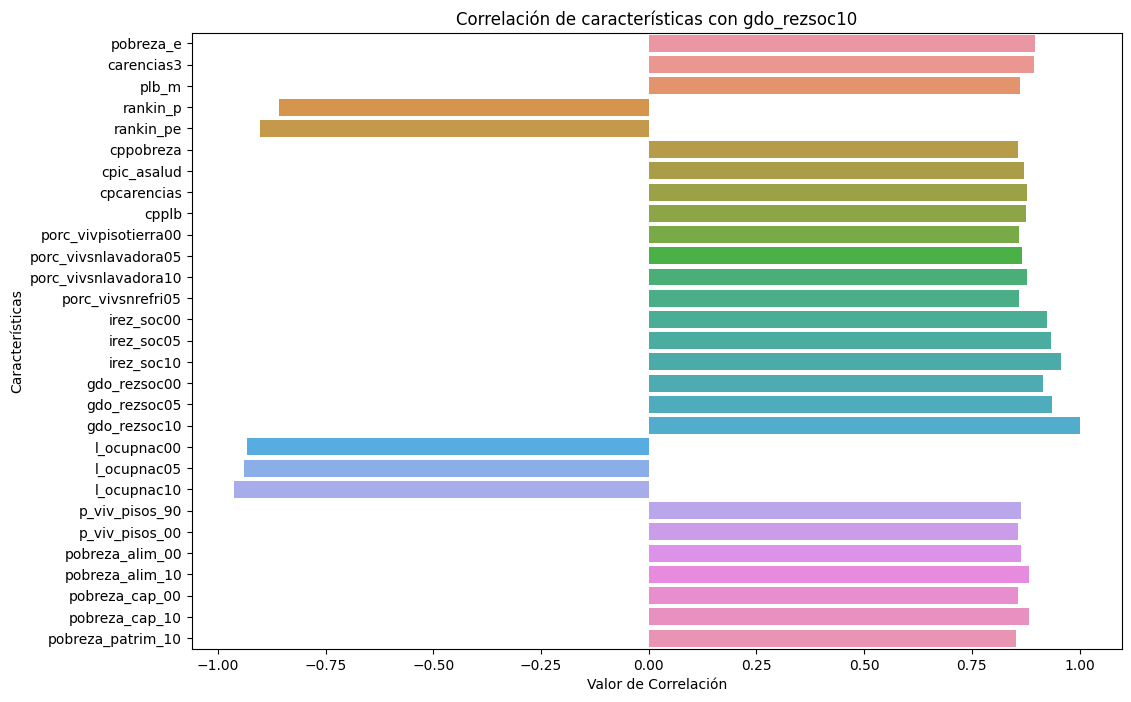

In [9]:
#Show correlation values

plt.figure(figsize=(12, 8))
sns.barplot(x=filtered_correlation.values, y=filtered_correlation.index)
plt.title('Correlación de características con gdo_rezsoc10')
plt.xlabel('Valor de Correlación')
plt.ylabel('Características')
plt.show()

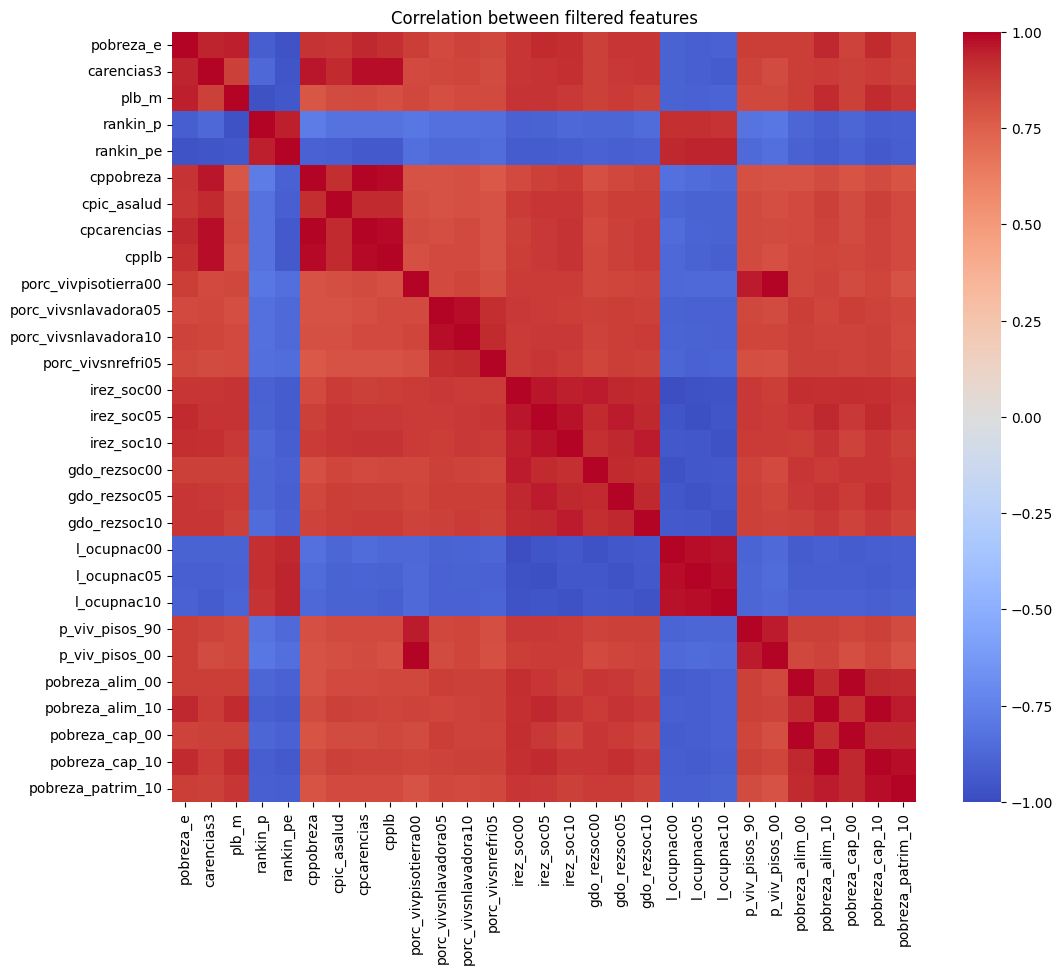

In [10]:
correlation_matrix_x = x_data.corr()

plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix_x, annot=False, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation between filtered features')
plt.show()

In [11]:
correlation_matrix_x

,pobreza_e,carencias3,plb_m,rankin_p,rankin_pe,cppobreza,cpic_asalud,cpcarencias,cpplb,porc_vivpisotierra00,...,l_ocupnac00,l_ocupnac05,l_ocupnac10,p_viv_pisos_90,p_viv_pisos_00,pobreza_alim_00,pobreza_alim_10,pobreza_cap_00,pobreza_cap_10,pobreza_patrim_10
pobreza_e,1.000000,0.943602,0.950241,-0.916827,-0.960984,0.905985,0.892987,0.932554,0.913977,0.872881,...,-0.893720,-0.906840,-0.905734,0.872074,0.870553,0.868604,0.933111,0.855403,0.923294,0.870240
carencias3,0.943602,1.000000,0.861016,-0.870669,-0.958127,0.966796,0.927452,0.981639,0.979791,0.828663,...,-0.896544,-0.911181,-0.925170,0.853467,0.825628,0.868757,0.877738,0.864637,0.882807,0.865221
plb_m,0.950241,0.861016,1.000000,-0.972098,-0.949532,0.782644,0.826084,0.829766,0.817048,0.837744,...,-0.897814,-0.900532,-0.890484,0.840523,0.836704,0.867838,0.929181,0.861195,0.927485,0.895324
rankin_p,-0.916827,-0.870669,-0.972098,1.000000,0.951178,-0.776636,-0.821509,-0.826873,-0.824874,-0.800192,...,0.909961,0.912389,0.901196,-0.816069,-0.797373,-0.880091,-0.911869,-0.881130,-0.920879,-0.912914
rankin_pe,-0.960984,-0.958127,-0.949532,0.951178,1.000000,-0.905167,-0.909915,-0.931200,-0.931830,-0.840449,...,0.931454,0.943186,0.943861,-0.860528,-0.839937,-0.902696,-0.925847,-0.901842,-0.933499,-0.920758
cppobreza,0.905985,0.966796,0.782644,-0.776636,-0.905167,1.000000,0.920110,0.993277,0.986899,0.797431,...,-0.830396,-0.858349,-0.874299,0.811208,0.797585,0.801575,0.826586,0.796873,0.825577,0.794413
cpic_asalud,0.892987,0.927452,0.826084,-0.821509,-0.909915,0.920110,1.000000,0.926235,0.925986,0.817604,...,-0.876232,-0.890867,-0.897853,0.832371,0.817986,0.831430,0.861938,0.828002,0.861902,0.835844
cpcarencias,0.932554,0.981639,0.829766,-0.826873,-0.931200,0.993277,0.926235,1.000000,0.987036,0.821245,...,-0.859113,-0.882813,-0.897830,0.834542,0.820556,0.829549,0.858105,0.824539,0.857913,0.828345
cpplb,0.913977,0.979791,0.817048,-0.824874,-0.931830,0.986899,0.925986,0.987036,1.000000,0.809243,...,-0.873457,-0.893629,-0.909065,0.831594,0.809091,0.841331,0.848923,0.840020,0.852526,0.832353
porc_vivpisotierra00,0.872881,0.828663,0.837744,-0.800192,-0.840449,0.797431,0.817604,0.821245,0.809243,1.000000,...,-0.870692,-0.859943,-0.861857,0.956797,0.996348,0.838003,0.859016,0.821487,0.849673,0.798225


In [12]:
# List to storage columns to drop
columns_to_drop = []

# Navigate the correlation matrix, marking columns to remove, considering only one side of the diagonal to avoid redundancy
for i in range(len(correlation_matrix_x.columns)):
    for j in range(i):
        if abs(correlation_matrix_x.iloc[i, j]) > 0.98:  # Threshold
            colname = correlation_matrix_x.columns[i]  # Get the feature
            columns_to_drop.append(colname)

# Drop high correlated columns and label
columns_to_drop.append('gdo_rezsoc10')

x_data_reduced = x_data.drop(columns=columns_to_drop)

In [13]:
x_data_reduced

,pobreza_e,carencias3,plb_m,rankin_p,rankin_pe,cppobreza,cpic_asalud,porc_vivpisotierra00,porc_vivsnlavadora05,porc_vivsnlavadora10,...,irez_soc05,irez_soc10,gdo_rezsoc00,gdo_rezsoc05,l_ocupnac05,l_ocupnac10,p_viv_pisos_90,pobreza_alim_00,pobreza_alim_10,pobreza_patrim_10
0,2.264478,10.058793,10.313890,2351,2385,1.905452,2.327308,2.323120,15.390470,15.126000,...,-1.636908,-1.558484,0,0,2421.0,2415,5.0,7.6,11.805700,41.900398
1,8.040704,18.978608,32.202774,1340,1915,1.938898,2.551830,10.225560,29.297331,26.991110,...,-0.956417,-1.014475,0,0,2000.0,2074,14.8,22.1,21.993299,59.175800
2,7.241238,19.001278,26.503269,1601,1989,1.904336,2.438658,4.876200,23.028191,19.993771,...,-1.122184,-1.101936,0,0,2143.0,2145,8.7,24.2,19.266800,56.504902
3,4.769001,14.062565,20.853953,1930,2196,1.765410,2.495737,6.019660,32.632671,32.813850,...,-1.078457,-1.133137,0,0,2103.0,2172,19.2,14.9,14.303200,51.164501
4,6.084037,15.777625,19.469262,2108,2072,1.953392,2.390123,6.924010,19.969540,18.911690,...,-1.210941,-1.296495,0,0,2209.0,2288,13.6,15.9,15.085100,45.703899
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2451,12.301183,27.413508,38.365505,1010,1603,2.115268,2.730348,17.047230,36.955929,29.985991,...,-0.312786,-0.516928,2,1,1396.0,1580,32.7,47.9,30.055300,70.859596
2452,10.203506,27.175685,29.403145,1416,1748,2.233191,2.522609,5.319010,25.617580,19.989780,...,-0.854362,-0.837487,0,0,1908.0,1887,8.9,20.0,13.138800,46.659199
2453,3.535624,9.782853,10.664958,2364,2298,1.990281,2.562583,1.754390,13.642270,12.136880,...,-1.702367,-1.608179,0,0,2437.0,2430,2.6,14.2,7.164800,32.302700
2454,14.607016,24.531247,45.556403,837,1445,2.020143,2.944920,9.042330,30.325979,26.442181,...,-0.528991,-0.723152,1,1,1598.0,1768,14.2,29.4,21.285900,57.394501


## Outlayers handling

In [14]:
# Using Z-score to detect outlayers
z_scores = (x_data_reduced - x_data_reduced.mean()) / x_data_reduced.std()

has_outliers = (z_scores.abs() > 3).any().any()
print(has_outliers)

True


In [15]:
outliers = z_scores.abs() > 3

# Replace outlayers with high and low no atipic values
for column in x_data_reduced.columns:
    upper_limit = x_data_reduced[column][~outliers[column]].max()
    lower_limit = x_data_reduced[column][~outliers[column]].min()
    x_data_reduced[column] = np.where(z_scores[column] > 3, upper_limit, x_data_reduced[column])
    x_data_reduced[column] = np.where(z_scores[column] < -3, lower_limit, x_data_reduced[column])

# Check if there is outlayers left:
z_scores_after_replacement = (x_data_reduced - x_data_reduced.mean()) / x_data_reduced.std()
outliers_after_replacement = z_scores_after_replacement.abs() > 3

has_outliers_after_replacement = outliers_after_replacement.any().any()

has_outliers_after_replacement

False

In [16]:
X_train, X_test, Y_train, Y_test = train_test_split(x_data_reduced, y_data, test_size=0.2, random_state=42) #Get train and test datasets

In [17]:
# Normalize features

scaler = MinMaxScaler()

X_train_normalized_array = scaler.fit_transform(X_train)
X_train = pd.DataFrame(X_train_normalized_array, columns=X_train.columns)

X_test_normalized_array = scaler.transform(X_test)
X_test = pd.DataFrame(X_test_normalized_array, columns=X_test.columns)
X_train

,pobreza_e,carencias3,plb_m,rankin_p,rankin_pe,cppobreza,cpic_asalud,porc_vivpisotierra00,porc_vivsnlavadora05,porc_vivsnlavadora10,...,irez_soc05,irez_soc10,gdo_rezsoc00,gdo_rezsoc05,l_ocupnac05,l_ocupnac10,p_viv_pisos_90,pobreza_alim_00,pobreza_alim_10,pobreza_patrim_10
0,0.425722,0.505039,0.669753,0.148269,0.280359,0.423757,0.669588,0.545563,0.823084,0.613972,...,0.645656,0.515997,1.00,0.75,0.128874,0.261614,0.835836,0.758693,0.701180,0.895979
1,0.222286,0.499136,0.323489,0.522607,0.515485,0.444984,0.480824,0.246707,0.752071,0.621523,...,0.532702,0.504570,0.75,0.75,0.244290,0.278321,0.314314,0.229715,0.251968,0.507846
2,0.857055,0.877906,0.877237,0.022403,0.015485,0.775769,0.741423,0.824520,0.979344,0.953663,...,0.711101,0.656801,0.75,0.75,0.083197,0.118989,0.880881,0.821918,0.862828,0.957058
3,0.404508,0.658494,0.539841,0.312831,0.302363,0.594540,0.656077,0.682950,0.925322,0.858611,...,0.521215,0.526723,0.75,0.50,0.260196,0.244091,0.745746,0.738672,0.591327,0.868505
4,0.269078,0.471318,0.352043,0.589409,0.462103,0.510120,0.429709,0.361206,0.687723,0.588939,...,0.426488,0.379121,0.50,0.50,0.424144,0.474735,0.429429,0.454162,0.228710,0.524665
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1959,0.260804,0.394269,0.377861,0.583707,0.469438,0.483330,0.470466,0.335443,0.670304,0.569551,...,0.350331,0.355748,0.25,0.25,0.550163,0.513447,0.377377,0.457323,0.445323,0.722860
1960,0.851157,0.922480,0.847144,0.033401,0.017115,0.774102,0.683761,0.809259,0.981282,0.863634,...,0.729335,0.765708,0.75,0.75,0.070555,0.053382,0.902903,0.897787,0.701601,0.914347
1961,0.603696,0.830241,0.640956,0.196334,0.143847,0.703434,0.908661,0.934047,0.997486,0.922938,...,0.758946,0.822441,1.00,0.75,0.054649,0.032192,0.977978,0.697576,0.688707,0.911825
1962,0.761768,0.936676,0.750120,0.079430,0.051345,0.822631,0.791262,0.694383,0.979886,0.955414,...,0.764671,0.789295,1.00,0.75,0.050979,0.043195,0.959960,0.844046,0.782422,0.949368


# KNN

## KNN from Scratch

In [20]:
#Training function, here is calculated the euclidean distance with the square root of the sumation of the square differences
#sqrt((x1 - x2)**2)
def training(train, test, Y_train):
  distances = [] #Define an empty list to get the final distances

  for i in range(len(test)):
    distances_i = []
    for j in range(len(train)):
      squares = 0 #Variable where the sumation will be saved

      for k in range(len(train.columns)): #There are three for's loops to get each feature of the training dataset in relation with each point of the test dataset
        #Euclidean distance
        points = (test.iloc[i,k] - train.iloc[j,k])**2
        squares = squares + points
      distance = sqrt(squares)
      distance = round(distance, 3)

      #Save the distances in lists inside a list
      distances_i.append((distance, Y_train.iloc[j])) #It will get a tupple of the distance and the label

    distances.append(distances_i) #Save the sublist in the distance list

  return distances


In [21]:
def classify(distances, k):
  sorted_list = [] #Define empty list to get the sorted sublists, the sorted labels and the prediction the algorithm did
  labels = []
  prediction = []

  for i in range(len(distances)):
    sublist = distances[i] #Get the i sublist of the greater list and sort it
    sublist.sort()
    labels_0 = [] #Define an empty list to get the sorted labels
    Zero, One, Two, Three, Four = 0, 0, 0, 0, 0

    for j in range(k):
      element = sublist[j]
      labels_0.append(element[1])

      #Count the nearest labels
      if element[1] == 0.0:
        Zero += 1
      elif element[1] == 1.0:
        One += 1
      elif element[1] == 2.0:
        Two += 1
      elif element[1] == 3.0:
        Three += 1
      elif element[1] == 4.0:
        Four += 1

    #Classify depeding in the most common label
    if max(Zero, One, Two, Three, Four) == Zero:
      prediction.append(0)
    elif max(Zero, One, Two, Three, Four) == One:
      prediction.append(1)
    elif max(Zero, One, Two, Three, Four) == Two:
      prediction.append(2)
    elif max(Zero, One, Two, Three, Four) == Three:
      prediction.append(3)
    elif max(Zero, One, Two, Three, Four) == Four:
      prediction.append(4)

    labels.append(labels_0) #Save the sublist in the graters list
    sorted_list.append(sublist)

  return sorted_list, labels, prediction

In [22]:
def accuracy(prediction, Y_test):
  Y_test = Y_test.reset_index(drop=True)
  correct = 0 #Define a variable to store the count of correct predictions

  for i in range(len(Y_test)):
    if prediction[i] == Y_test[i]:  #If is the same label it will add 1 to the variable
      correct += 1

  accuracy = (correct/len(Y_test))*100 #Divide the correct predictions by the numbers of labels

  return accuracy

In [23]:
distances = training(X_train, X_test, Y_train)

In [24]:
listsorted, labels, predictions = classify(distances, 3)

In [28]:
Knn_accuracy = accuracy(predictions, Y_test)

In [29]:
Knn_accuracy

84.34959349593495

## Library KNN

In [30]:
knn = KNeighborsClassifier(n_neighbors = 3)

# Train KNN
knn.fit(X_train, Y_train)

# Predict
y_pred = knn.predict(X_test)

# Get accuracy
accuracy = accuracy_score(Y_test, y_pred)
accuracy

0.8414634146341463

# Perceptron - Multiclass

## Perceptron from Scratch

In [31]:
def accuracy(prediction, Y_test):
  correct = 0 #Define a variable to store the count of correct predictions

  for i in range(len(prediction)):
    if prediction[i] == Y_test[i]:  #If is the same label it will add 1 to the variable
      correct += 1

  accuracy = (correct/len(Y_test))*100 #Divide the correct predictions by the numbers of labels

  return accuracy


def step(y): #Define step function (Activation function)
    if y >= 0:
        f = 1
    else:
        f = -1
    return f

def opt(error, x_train, w, b, learning_rate): #Define optimization function
    Nweights = w + learning_rate * error * x_train
    Nbias = b + learning_rate * error

    return Nweights, Nbias

def training(learning_rate, epochs, x_train, y_train, No_classes):
    # Change pandas DataFrame to numpy arrays
    x_train = np.array(x_train)
    y_train = np.array(y_train)

    num_samples, num_features = x_train.shape #Variables to get determined weights and biases
    all_weights = []
    all_biases = []

    for h in range(No_classes):
        weights = np.zeros(num_features) # Initialize weights and bias
        bias = 0

        # Create a new dataset "y_train_temp" replacing classes (To multiclass to binary)
        y_train_temp = np.where(np.isin(y_train, h), 1, -1)

        print(f"\nClass {h} training")

        for i in range(epochs):
            predictions = [] # Set variables to get the predictions and the total error
            error_t = 0

            for j in range(len(x_train)):
                y = np.dot(x_train[j], weights) + bias #Calculate output (x*w + b)
                predict = step(y) # Apply activation function
                predictions.append(predict) #Add prediction made (by perceptron and activation function) to prediction list

                error = y_train_temp[j] - predict # Calculate error in the prediction
                error_t += abs(error)

                if error != 0: # Optimize in case of error
                    weights, bias = opt(error, x_train[j], weights, bias, learning_rate)

            Merror = error_t / len(x_train)
            print("Epoch: ", i, "Mean Error: ", Merror)

        all_weights.append(weights) # Get all weights and biases
        all_biases.append(bias)


    return all_weights, all_biases

In [32]:
def test(x_test, y_test, all_weights, all_biases):
    # Change pandas DataFrame to numpy arrays
    x_test = np.array(x_test)
    y_test = np.array(y_test)

    predictions_test = [] # Set variables to store predictions

    for j in range(len(x_test)):
        outputs = [] # Get the outputs to compare

        # Compute the output for each perceptron
        for k in range(len(all_weights)):
          w = all_weights[k]
          b = all_biases[k]
          y = np.dot(x_test[j], w) + b
          outputs.append(y)


        # The class of the perceptron with the highest output is the predicted class
        predict = np.argmax(outputs)
        predictions_test.append(predict) #Prediction made according index in outputs list

    final_accuracy = accuracy(predictions_test, y_test)
    return predictions_test, final_accuracy

In [33]:
pesos, biases = training(0.01, 500, X_train, Y_train, 5)


Class 0 training
Epoch:  0 Mean Error:  0.1384928716904277
Epoch:  1 Mean Error:  0.09877800407331976
Epoch:  2 Mean Error:  0.08044806517311609
Epoch:  3 Mean Error:  0.0855397148676171
Epoch:  4 Mean Error:  0.07637474541751528
Epoch:  5 Mean Error:  0.0835030549898167
Epoch:  6 Mean Error:  0.054989816700611
Epoch:  7 Mean Error:  0.07230142566191446
Epoch:  8 Mean Error:  0.06517311608961303
Epoch:  9 Mean Error:  0.05091649694501019
Epoch:  10 Mean Error:  0.05804480651731161
Epoch:  11 Mean Error:  0.07739307535641547
Epoch:  12 Mean Error:  0.06924643584521385
Epoch:  13 Mean Error:  0.038696537678207736
Epoch:  14 Mean Error:  0.045824847250509164
Epoch:  15 Mean Error:  0.06720977596741344
Epoch:  16 Mean Error:  0.054989816700611
Epoch:  17 Mean Error:  0.03665987780040733
Epoch:  18 Mean Error:  0.04989816700610998
Epoch:  19 Mean Error:  0.06924643584521385
Epoch:  20 Mean Error:  0.04684317718940937
Epoch:  21 Mean Error:  0.034623217922606926
Epoch:  22 Mean Error:  0.03

In [34]:
prediciones, Perceptron_accuracy = test(X_test, Y_test, pesos, biases)

In [35]:
Perceptron_accuracy

92.47967479674797

## Library Perceptron

In [36]:
clf = OneVsRestClassifier(Perceptron(max_iter=1000, tol=1e-3))

# Train the classifier
clf.fit(X_train, Y_train)

# Predict
y_pred = clf.predict(X_test)

# Get accuracy
acc = accuracy_score(Y_test, y_pred)
print(f"Accuracy: {acc:.4f}")


Accuracy: 0.8232
